### Phase 4 (Modeling)

In [7]:
# Suppress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [16]:
# imports

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error

from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM, Activation, GRU
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras import optimizers


In [21]:
# Reading data to variables

X_train = pd.read_csv('../data/training_data/train/X_train.csv')
X_test = pd.read_csv('../data/training_data/test/X_test.csv')

y_train = pd.read_csv('../data/training_data/train/y_train.csv')
y_test = pd.read_csv('../data/training_data/test/y_test.csv')

   energy_sum
0       7.099
1      10.281
2      14.391
3       0.018
4       1.230
   energy_sum
0       5.049
1       3.518
2       5.881
3      13.846
4       3.382
[[3.74607528e-02]
 [5.42518659e-02]
 [7.59399489e-02]
 [9.49843007e-05]
 [6.49059388e-03]]
[[0.0266431 ]
 [0.01856415]
 [0.03103348]
 [0.07306403]
 [0.01784649]]


In [ ]:
# scale target variable

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1))

In [44]:
# save scaler instance for future use
import joblib
joblib.dump(scaler, '../scalers/y_scaler.save')

['../scalers/y_scaler.save']

In [23]:

def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        if isinstance(X, np.ndarray):
            X_seq.append(X[i:(i + sequence_length)])
        else:
            X_seq.append(X.iloc[i:(i + sequence_length)].values)
        
        if isinstance(y, np.ndarray):
            y_seq.append(y[i + sequence_length])
        else:
            y_seq.append(y.iloc[i + sequence_length])
    
    return np.array(X_seq), np.array(y_seq)

sequence_length = 7
X_train_seq, y_train_seq = create_sequences(X_train, y_train.squeeze(), sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test.squeeze(), sequence_length)


In [78]:
# building the model

n_features = X_train_seq.shape[2]
print(n_features)

LSTM_model = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(sequence_length, n_features)),
    Dropout(0.3),
    LSTM(units=64, return_sequences=True),
    Dropout(0.3),
    LSTM(units=32),
    Dropout(0.3),
    Dense(1)
])
GRU_model = Sequential([
    GRU(units=128, return_sequences=True, input_shape=(sequence_length, n_features)),
    Dropout(0.3),
    GRU(units=64, return_sequences=True),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

LSTM_model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])
GRU_model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])


39


In [32]:
# training LSTM model

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

LSTM_history = LSTM_model.fit(
    X_train_seq, 
    y_train_seq, 
    epochs=10, 
    batch_size=32, 
    validation_data=(X_test_seq, y_test_seq), 
    verbose=2, 
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/10
86037/86037 - 992s - loss: 0.0023 - mean_absolute_error: 0.0311 - val_loss: 0.0023 - val_mean_absolute_error: 0.0315 - lr: 0.0010 - 992s/epoch - 12ms/step
Epoch 2/10
86037/86037 - 968s - loss: 0.0023 - mean_absolute_error: 0.0311 - val_loss: 0.0023 - val_mean_absolute_error: 0.0308 - lr: 0.0010 - 968s/epoch - 11ms/step
Epoch 3/10
86037/86037 - 964s - loss: 0.0023 - mean_absolute_error: 0.0311 - val_loss: 0.0023 - val_mean_absolute_error: 0.0317 - lr: 0.0010 - 964s/epoch - 11ms/step
Epoch 4/10
86037/86037 - 957s - loss: 0.0023 - mean_absolute_error: 0.0311 - val_loss: 0.0023 - val_mean_absolute_error: 0.0309 - lr: 0.0010 - 957s/epoch - 11ms/step
Epoch 5/10
86037/86037 - 944s - loss: 0.0023 - mean_absolute_error: 0.0311 - val_loss: 0.0023 - val_mean_absolute_error: 0.0314 - lr: 0.0010 - 944s/epoch - 11ms/step
Epoch 6/10
86037/86037 - 949s - loss: 0.0023 - mean_absolute_error: 0.0311 - val_loss: 0.0023 - val_mean_absolute_error: 0.0318 - lr: 9.0484e-04 - 949s/epoch - 11ms/step


In [39]:
LSTM_model.save('../models/LSTM.h5')

In [79]:
# training GRU model

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

GRU_history = GRU_model.fit(
    X_train_seq, 
    y_train_seq, 
    epochs=10, 
    batch_size=64, 
    validation_data=(X_test_seq, y_test_seq), 
    verbose=2, 
    callbacks=[lr_scheduler, early_stopping]
)

GRU_model.save('../models/GRU.h5')

Epoch 1/10
43019/43019 - 971s - loss: 0.0023 - mean_absolute_error: 0.0311 - val_loss: 0.0023 - val_mean_absolute_error: 0.0310 - lr: 0.0010 - 971s/epoch - 23ms/step
Epoch 2/10


KeyboardInterrupt: 

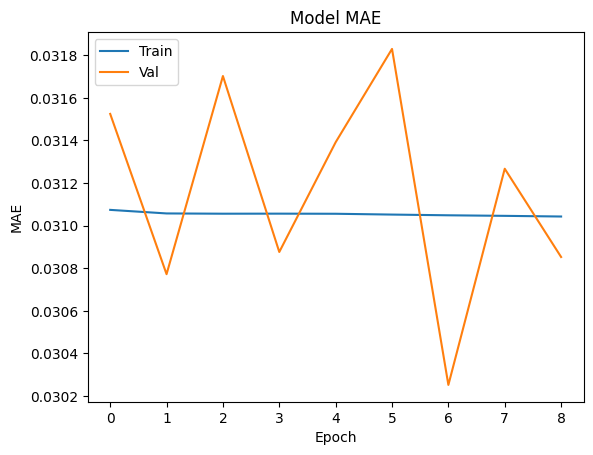

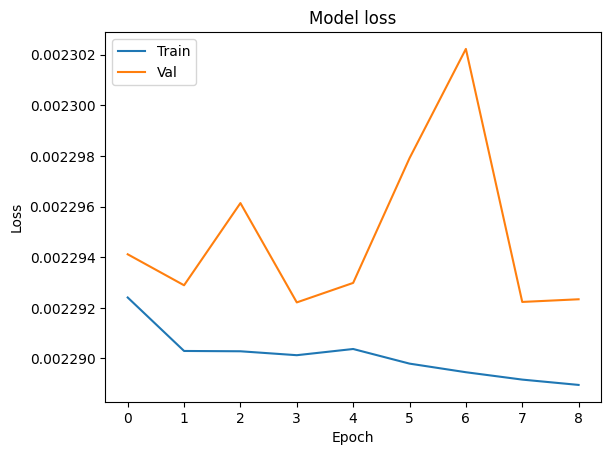

In [37]:
# Plot training & validation accuracy values
plt.plot(LSTM_history.history['mean_absolute_error'])
plt.plot(LSTM_history.history['val_mean_absolute_error'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(LSTM_history.history['loss'])
plt.plot(LSTM_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

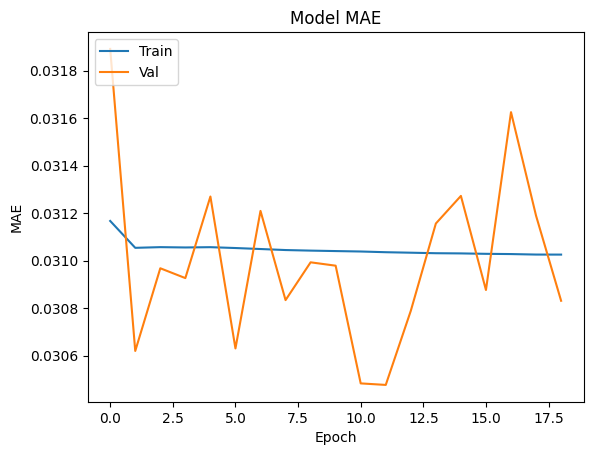

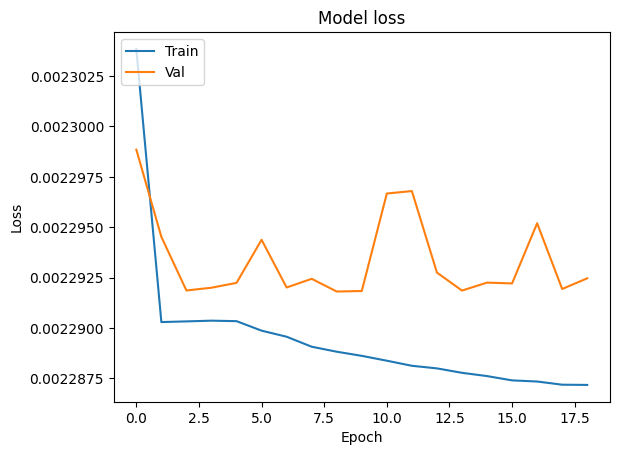

In [38]:
# Plot training & validation accuracy values
plt.plot(GRU_history.history['mean_absolute_error'])
plt.plot(GRU_history.history['val_mean_absolute_error'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(GRU_history.history['loss'])
plt.plot(GRU_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [58]:
# evaluation of LSTM
from keras.models import load_model

LSTM_from_file = load_model('../models/LSTM.h5')
X_scaler = joblib.load('../scalers/X_scaler.save')

LSTM_pred = LSTM_from_file.predict(X_test_seq)


21510/21510 [==============================] - 139s 6ms/step


In [59]:
print(LSTM_pred.shape)

(688289, 1)


In [68]:
# load y_scaler and invert transformations
y_scaler = joblib.load('../scalers/y_scaler.save')

y_test_actual = y_scaler.inverse_transform(y_test)
pred_actual = y_scaler.inverse_transform(LSTM_pred)

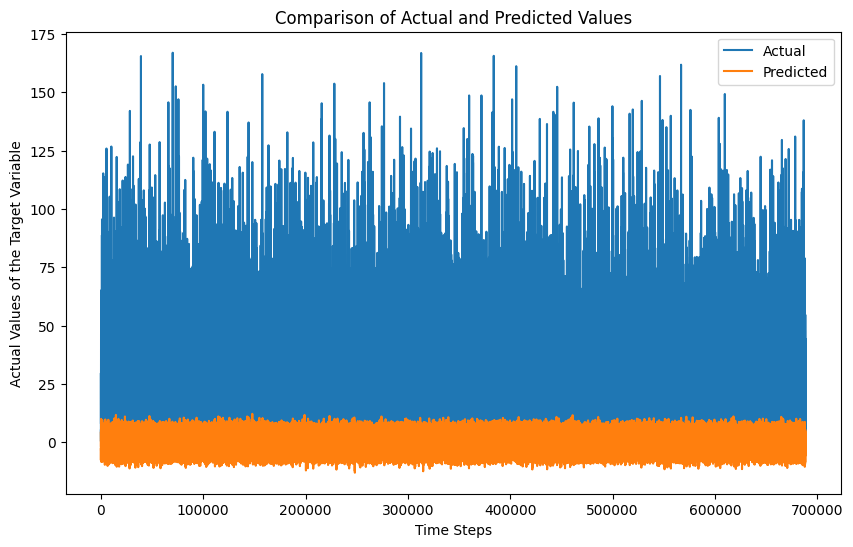

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(pred_actual, label='Predicted')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Actual Values of the Target Variable')
plt.legend()
plt.show()

In [75]:
GRU_from_file = load_model('../models/GRU.h5')

GRU_pred = GRU_from_file.predict(X_test_seq)
print(GRU_pred.max())
print(GRU_pred.min())
print(GRU_pred.shape)

21510/21510 [==============================] - 112s 5ms/step
0.053381946
0.053381745
(688289, 1)


In [74]:
y_test_actual = y_scaler.inverse_transform(y_test)
GRU_pred_actual = y_scaler.inverse_transform(GRU_pred)
print(GRU_pred_actual.max())
print(GRU_pred_actual.min())

10.116146
10.116108


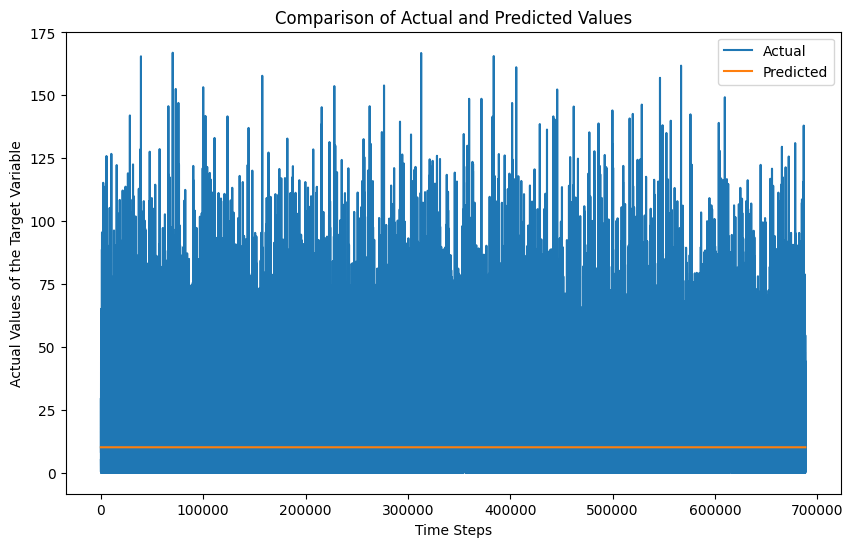

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(GRU_pred_actual, label='Predicted')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Actual Values of the Target Variable')
plt.legend()
plt.show()